In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

In [2]:
pth = os.path.join('..', '..')
pth_data = os.path.join(pth, 'data')
pth_in = os.path.join(pth_data, 'cancer')
pth_mod = os.path.join(pth_data, 'features', 'biomart', 'modules')
pth_out = os.path.join(pth, 'figures', 'cancer', 'CCCA', 'modules')

In [3]:
adata = sc.read_h5ad(os.path.join(pth_in, 'CCCA.h5ad'))
adata

AnnData object with n_obs × n_vars = 1406087 × 856
    obs: 'sample', 'cell_type', 'complexity', 'umap1', 'umap2', 'g1s_score', 'g2m_score', 'cell_cycle_phase', 'mp_top_score', 'mp_top', 'mp_assignment', 'ebv', 'celltype', 'Title', 'Category', 'Disease', 'Technology', 'Samples', 'Cells ', 'Name', 'patient', 'cell_subtype', 'source', 'disease', 'p16_status', 'site', 't_stage', 'n_stage', 'gender', 'race', 'age', 'tobacco_use', 'alcohol_use', 'hpv', 'hpv_score', 'treatment', 'procedure', 'sorting', 'cluster', 'malignant', 'sample_id', 'cell_subtype_clusters', 'tnm_stage', 'viral', 'location', 'cancer_type', 'treatment_exposure', 'treatment_response', 'cell_lineage', 'type', 'clusters_by_authors', 'cell_QCpass', 'is_tumor', 'cell_compartment', 'cluster_assignment', 'metastasis', 'sex', 'prior_enzalutamide', 'prior_abiraterone', 'prior_taxane', 'prior_platinum', 'prior_sipuleucel_T', 'purity', 'has_bulk_RNA', 'cancer_cell_state', 'PSA', 'source_region', 'gleason_score', 'ERG_status', 'core

In [4]:
mod_plt = ['Early', 'Late']
for mod in mod_plt:
    print(mod)
    fn = os.path.join(pth_mod, f'{mod.lower()}.csv')
    df_mod = pd.read_csv(fn)
    g = df_mod.mmusculus.copy()
    g = g.loc[g.isin(adata.var_names)]
    for _, df_group in adata.obs.groupby('source', observed = True):
        msk = adata.obs_names.isin(df_group.index)
        adata_group = adata[msk].copy()
        sc.tl.score_genes(adata_group,
                          gene_list = g,
                          ctrl_as_ref = False,
                          score_name = mod,
                          random_state = 1234)
        adata.obs.loc[msk, mod] = adata_group.obs[mod]

Early
Late


In [5]:
ix = ['Category', 'Disease', 'Name', 'source', 'sample']
df = (adata.obs.set_index(ix)[mod_plt] > 0).astype(float)

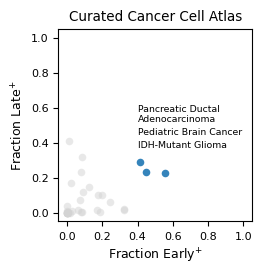

In [6]:
# plot diseases
s, pad, lim = 30, .05, (0, 1)
fig, ax = plt.subplots(1, 1, figsize = (2.5, 2.5))
df_plt = df.groupby('Disease', observed = True).mean()
msk = (df_plt.sum(axis = 1) > .5)
ax.scatter(df_plt.loc[~msk].Early,
           df_plt.loc[~msk].Late,
           c = 'lightgray',
           s = s, alpha = .5,
           linewidth = 0)
ax.scatter(df_plt.loc[msk].Early,
           df_plt.loc[msk].Late,
           c = 'tab:blue',
           s = s, alpha = .9,
           linewidth = 0)

ax.set_xlim(lim[0] - pad, lim[1] + pad)
ax.set_ylim(lim[0] - pad, lim[1] + pad)
ticks = np.arange(lim[0], lim[1] + .1, .2).round(1)
ax.set_xticks(ticks, ticks, size = 8)
ax.set_yticks(ticks, ticks, size = 8)

for i, ix in enumerate(
    df_plt.loc[msk].sort_values('Early').index):
    ax.text(.4, .52 - (i * .075), ix, size = 6.75)

label_dict = {
    'Pancreatic Ductal Adenocarcinoma' : \
        'Pancreatic Ductal\nAdenocarcinoma'}

for label in ax.texts:
    _label_ = label.get_text()
    if _label_ in label_dict:
        label.set_text(label_dict[_label_])

ax.set_title('Curated Cancer Cell Atlas', size = 9.75)
ax.set_xlabel(r'Fraction Early$^{+}$', size = 9)
ax.set_ylabel(r'Fraction Late$^{+}$', size = 9)
fn = os.path.join(pth_out, 'disease.pdf')
plt.savefig(fn, bbox_inches = 'tight')

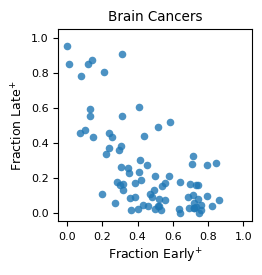

In [7]:
groupby = ['Name', 'source', 'sample']
disease_plt = ['Pediatric Brain Cancer',
               'IDH-Mutant Glioma']

# plot brain cancers
fig, ax = plt.subplots(1, 1, figsize = (2.5, 2.5))
df_plt = (df.loc['Brain'].loc[disease_plt]
          .groupby(groupby, observed = True).mean())
ax.scatter(df_plt.Early,
           df_plt.Late,
           c = 'tab:blue',
           s = s, alpha = .8,
           linewidth = 0)

ax.set_xlim(lim[0] - pad, lim[1] + pad)
ax.set_ylim(lim[0] - pad, lim[1] + pad)
ax.set_xticks(ticks, ticks, size = 8)
ax.set_yticks(ticks, ticks, size = 8)
ax.set_title('Brain Cancers', size = 9.75)
ax.set_xlabel(r'Fraction Early$^{+}$', size = 9)
ax.set_ylabel(r'Fraction Late$^{+}$', size = 9)
fn = os.path.join(pth_out, 'brain.pdf')
plt.savefig(fn, bbox_inches = 'tight')

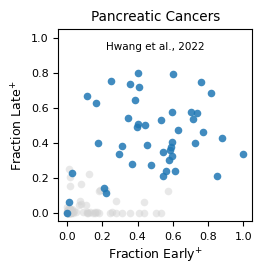

In [10]:
# plot pancreatic cancers
fig, ax = plt.subplots(1, 1, figsize = (2.5, 2.5))
df_plt = (df.loc['Pancreas'].groupby(
          groupby, observed = True).mean())
msk = (df_plt.index.get_level_values(0) == \
       'Data_Hwang2022_Pancreas')
ax.scatter(df_plt.loc[~msk].Early,
           df_plt.loc[~msk].Late,
           c = 'lightgray',
           s = s, alpha = .5,
           linewidth = 0)
ax.scatter(df_plt.loc[msk].Early,
           df_plt.loc[msk].Late,
           c = 'tab:blue',
           s = s, alpha = .85,
           linewidth = 0)

ax.text(.5, .95,
        'Hwang et al., 2022',
        ha = 'center',
        va = 'center',
        size = 7.5)

ax.set_xlim(lim[0] - pad, lim[1] + pad)
ax.set_ylim(lim[0] - pad, lim[1] + pad)
ax.set_xticks(ticks, ticks, size = 8)
ax.set_yticks(ticks, ticks, size = 8)
ax.set_title('Pancreatic Cancers', size = 9.75)
ax.set_xlabel(r'Fraction Early$^{+}$', size = 9)
ax.set_ylabel(r'Fraction Late$^{+}$', size = 9)
fn = os.path.join(pth_out, 'pancreas.pdf')
plt.savefig(fn, bbox_inches = 'tight')